BI名企班，谢雅楠，20201220

### Action1
基于评分卡的风控模型开发  
数据集GiveMeSomeCredit，15万样本数据
https://www.kaggle.com/c/GiveMeSomeCredit/data  
使用WOE进行特征变换，IV进行特征筛选，LR构建风控模型，并对模型评分规则进行可解释性说明 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [2]:
df_train = pd.read_csv('cs-training.csv')
df_test = pd.read_csv('cs-test.csv')

In [3]:
df_train

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [4]:
df_train.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

### 1. EDA

In [5]:
## SeriousDlqin2yrs
df_train['SeriousDlqin2yrs'].value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

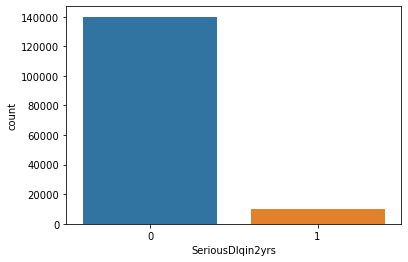

In [6]:
sns.countplot(x='SeriousDlqin2yrs', data=df_train)

In [7]:
## missing value
df_train.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [8]:
df_train['RevolvingUtilizationOfUnsecuredLines'].describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

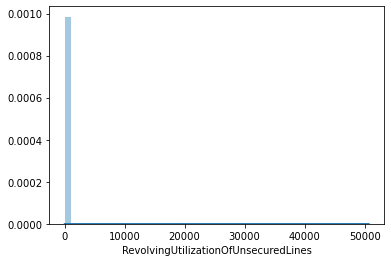

In [9]:
## RevolvingUtilizationOfUnsecuredLines
sns.distplot(df_train['RevolvingUtilizationOfUnsecuredLines'])

### 2. 缺失值

In [10]:
df_train = df_train.fillna(df_train.median())

In [11]:
df_train.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### 3.数据分箱
1）对于age字段，分成6段 [-math.inf, 25, 40, 50, 60, 70, math.inf]  
2）对于NumberOfDependents（家属人数）字段，分成6段
 [-math.inf,2,4,6,8,10,math.inf]  
3）对于3种逾期次数，即NumberOfTime30-59DaysPastDueNotWorse，NumberOfTime60-89DaysPastDueNotWorse，NumberOfTimes90DaysLate，分成10段
[-math.inf,1,2,3,4,5,6,7,8,9,math.inf]  
4）对于其余字段，即RevolvingUtilizationOfUnsecuredLines, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines 分成5段


In [12]:
## age
age_bins = [-math.inf, 25, 40, 50, 60, 70, math.inf]  
df_train['bin_age'] = pd.cut(df_train['age'], bins=age_bins)

In [13]:
## dependent
dependent_bins = [-math.inf,2,4,6,8,10,math.inf]
df_train['bin_NumberOfDependents'] = pd.cut(df_train['NumberOfDependents'], bins=dependent_bins)
# df_train[['NumberOfDependents','bin_NumberOfDependents']]

In [14]:
## NumberOfTime30-59DaysPastDueNotWorse，
## NumberOfTime60-89DaysPastDueNotWorse，
## NumberOfTimes90DaysLate
dpd_bins = [-math.inf,1,2,3,4,5,6,7,8,9,math.inf]  
df_train['bin_NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(df_train['NumberOfTime30-59DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTime60-89DaysPastDueNotWorse']= pd.cut(df_train['NumberOfTime60-89DaysPastDueNotWorse'], bins=dpd_bins)
df_train['bin_NumberOfTimes90DaysLate']= pd.cut(df_train['NumberOfTimes90DaysLate'], bins=dpd_bins)

In [15]:
## RevolvingUtilizationOfUnsecuredLines, 
## DebtRatio, 
## MonthlyIncome, 
## NumberOfOpenCreditLinesAndLoans, 
## NumberRealEstateLoansOrLines
df_train['bin_RevolvingUtilizationOfUnsecuredLines'] = pd.qcut(df_train['RevolvingUtilizationOfUnsecuredLines'], q=5, duplicates='drop') 
df_train['bin_DebtRatio'] = pd.qcut(df_train['DebtRatio'], q=5, duplicates='drop') 
df_train['bin_MonthlyIncome'] = pd.qcut(df_train['MonthlyIncome'], q=5, duplicates='drop') 
df_train['bin_NumberOfOpenCreditLinesAndLoans'] = pd.qcut(df_train['NumberOfOpenCreditLinesAndLoans'], q=5, duplicates='drop') 
df_train['bin_NumberRealEstateLoansOrLines'] = pd.qcut(df_train['NumberRealEstateLoansOrLines'], q=5, duplicates='drop') 

In [16]:
bin_cols = [c for c in df_train.columns.values if c.startswith('bin_')]
bin_cols

['bin_age',
 'bin_NumberOfDependents',
 'bin_NumberOfTime30-59DaysPastDueNotWorse',
 'bin_NumberOfTime60-89DaysPastDueNotWorse',
 'bin_NumberOfTimes90DaysLate',
 'bin_RevolvingUtilizationOfUnsecuredLines',
 'bin_DebtRatio',
 'bin_MonthlyIncome',
 'bin_NumberOfOpenCreditLinesAndLoans',
 'bin_NumberRealEstateLoansOrLines']

### 4.特征筛选
使用IV值衡量自变量的预测能力，筛选IV值>0.1的特征字段


In [17]:
def cal_IV(df, feature, target):
    lst = []
    cols = ['Variable', 'Value', 'All', 'Bad']
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, 
                    val, 
                    len(df[df[feature]==val]), 
                    len(df[(df[feature]==val) & (df[target] == 1)])])
    # print(lst)
    data = pd.DataFrame(lst, columns=cols)
    data = data[data['Bad'] > 0]
    
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Margin Bad'] = data['Bad'] / data['Bad'].sum()
    data['Margin Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['woe'] = np.log(data['Margin Bad'] / data['Margin Good'])
    data['iv'] =  (data['woe'] * (data['Margin Bad'] - data['Margin Good'])).sum()
    data = data.sort_values(by=['Variable', 'Value'])
    # print(data)
    return data['iv'].values[0]
    
    


cal_IV(df_train, 'bin_age', 'SeriousDlqin2yrs')

0.24041120302785982

In [18]:
for f in bin_cols:
    print(f)
    print(cal_IV(df_train, f, 'SeriousDlqin2yrs'))
    print()

bin_age
0.24041120302785982

bin_NumberOfDependents
0.01450836007644442

bin_NumberOfTime30-59DaysPastDueNotWorse
0.492444774570198

bin_NumberOfTime60-89DaysPastDueNotWorse
0.2665587583516951

bin_NumberOfTimes90DaysLate
0.49160685733515563

bin_RevolvingUtilizationOfUnsecuredLines
1.0596188771423887

bin_DebtRatio
0.05948761145809681

bin_MonthlyIncome
0.05623446147714756

bin_NumberOfOpenCreditLinesAndLoans
0.04802315528985505

bin_NumberRealEstateLoansOrLines
0.0120914141106244



In [19]:
## iv>0.1
# bin_age
# bin_NumberOfTime30-59DaysPastDueNotWorse
# bin_NumberOfTime60-89DaysPastDueNotWorse
# bin_NumberOfTimes90DaysLate
# bin_RevolvingUtilizationOfUnsecuredLines
feature_cols = ['bin_age',
                'bin_NumberOfTime30-59DaysPastDueNotWorse',
                'bin_NumberOfTime60-89DaysPastDueNotWorse',
                'bin_NumberOfTimes90DaysLate',
                'bin_RevolvingUtilizationOfUnsecuredLines']



### 5. 对于筛选出来的特征，计算每个bin的WOE值

In [20]:
def cal_WOE(df, features, target):
    df_new = df.copy()
    for f in features:
        df_woe = df_new.groupby(f).agg({target:['sum', 'count']})
        df_woe.columns = list(map(''.join, df_woe.columns.values))
        df_woe = df_woe.reset_index()
        df_woe = df_woe.rename(columns={target+'sum': 'bad', target+'count': 'all'})
        
        df_woe['good'] = df_woe['all'] - df_woe['bad']
        df_woe['margin bad'] = df_woe['bad'] / df_woe['bad'].sum()
        df_woe['margin good'] = df_woe['good'] / df_woe['good'].sum()
        df_woe['woe'] =  np.log1p(df_woe['margin bad'] / df_woe['margin good'])
        
        df_woe.columns = [c if c==f else c+'_'+f for c in list(df_woe.columns.values)]
        # print(df_woe)
        df_new = df_new.merge(df_woe, on=f, how='left')
    return df_new



df_woe =  cal_WOE(df_train, bin_cols, 'SeriousDlqin2yrs')
df_woe

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,good_bin_NumberOfOpenCreditLinesAndLoans,margin bad_bin_NumberOfOpenCreditLinesAndLoans,margin good_bin_NumberOfOpenCreditLinesAndLoans,woe_bin_NumberOfOpenCreditLinesAndLoans,bad_bin_NumberRealEstateLoansOrLines,all_bin_NumberRealEstateLoansOrLines,good_bin_NumberRealEstateLoansOrLines,margin bad_bin_NumberRealEstateLoansOrLines,margin good_bin_NumberRealEstateLoansOrLines,woe_bin_NumberRealEstateLoansOrLines
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,25838,0.184121,0.184591,0.691873,841,9952,9111,0.083882,0.065091,0.827981
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,30556,0.309495,0.218298,0.882845,7420,108526,101106,0.740076,0.722320,0.705363
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,30556,0.309495,0.218298,0.882845,7420,108526,101106,0.740076,0.722320,0.705363
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,24972,0.156892,0.178405,0.630962,7420,108526,101106,0.740076,0.722320,0.705363
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,35145,0.201177,0.251082,0.588475,7420,108526,101106,0.740076,0.722320,0.705363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,...,30556,0.309495,0.218298,0.882845,7420,108526,101106,0.740076,0.722320,0.705363
149996,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,...,30556,0.309495,0.218298,0.882845,7420,108526,101106,0.740076,0.722320,0.705363
149997,0,0.246044,58,0,3870.000000,5400.0,18,0,1,0,...,25838,0.184121,0.184591,0.691873,7420,108526,101106,0.740076,0.722320,0.705363
149998,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,...,30556,0.309495,0.218298,0.882845,7420,108526,101106,0.740076,0.722320,0.705363


In [21]:
feature_cols = ['age',
                'NumberOfTime30-59DaysPastDueNotWorse',
                'NumberOfTime60-89DaysPastDueNotWorse',
                'NumberOfTimes90DaysLate',
                'RevolvingUtilizationOfUnsecuredLines']

feature_cols

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'RevolvingUtilizationOfUnsecuredLines']

In [22]:
df_bin_to_woe = pd.DataFrame(columns = ['features', 'bin', 'woe'])
for f in feature_cols:
    b = 'bin_'+f
    w = 'woe_bin_' + f
    df = df_woe[[w,b]].drop_duplicates()
    df.columns = ['woe', 'bin']
    df['features'] = f
    df_bin_to_woe = pd.concat([df_bin_to_woe, df])
#     print(df)
df_bin_to_woe

,features,bin,woe
0,age,"(40.0, 50.0]",0.813822
1,age,"(25.0, 40.0]",0.955231
5,age,"(70.0, inf]",0.279404
6,age,"(50.0, 60.0]",0.651655
15,age,"(60.0, 70.0]",0.406848
19,age,"(-inf, 25.0]",1.013134
0,NumberOfTime30-59DaysPastDueNotWorse,"(1.0, 2.0]",1.797837
1,NumberOfTime30-59DaysPastDueNotWorse,"(-inf, 1.0]",0.572521
13,NumberOfTime30-59DaysPastDueNotWorse,"(2.0, 3.0]",2.151185
183,NumberOfTime30-59DaysPastDueNotWorse,"(3.0, 4.0]",2.429111


### 6. 使用逻辑回归进行建模

In [23]:
woe_cols = [c for c in list(df_woe.columns.values) if 'woe' in c]
woe_cols

['woe_bin_age',
 'woe_bin_NumberOfDependents',
 'woe_bin_NumberOfTime30-59DaysPastDueNotWorse',
 'woe_bin_NumberOfTime60-89DaysPastDueNotWorse',
 'woe_bin_NumberOfTimes90DaysLate',
 'woe_bin_RevolvingUtilizationOfUnsecuredLines',
 'woe_bin_DebtRatio',
 'woe_bin_MonthlyIncome',
 'woe_bin_NumberOfOpenCreditLinesAndLoans',
 'woe_bin_NumberRealEstateLoansOrLines']

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_woe[woe_cols], 
                                                    df_woe['SeriousDlqin2yrs'], 
                                                    test_size=0.2,
                                                    random_state=1234)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

model = LogisticRegression(random_state=1234).fit(x_train, y_train)
y_pred = model.predict(x_test)
print('accuracy: ', accuracy_score(y_pred, y_test))
print('auc: ', roc_auc_score(y_pred, y_test))

accuracy:  0.9361
auc:  0.7670665397646408


### 对评分卡模型的规则进行说明
基准分 A=650， PDO=50， 各变量对分箱评分规则存储在df score_card

In [32]:
## PDO=50 -> B=72.13
## odds=1 P0=650 -> A=650

def generate_scorecard(model_coef, binning_df, features, B):
    lst = []
    cols = ['Variable', 'Binning', 'Score']
    coef = model_coef[0]
    # print(coef)
    for i in range(len(features)):
        f = features[i]
        df = binning_df[binning_df['features'] == f]
        for index, row in df.iterrows():
            score = int(round(-coef[i] * row['woe'] * B))
            lst.append([f, row['bin'], score])
    data = pd.DataFrame(lst, columns=cols)
    return data



In [33]:
A,B = 650, 72.13
score_card = generate_scorecard(model.coef_, 
                                df_bin_to_woe,
                                feature_cols,
                                B)
score_card

,Variable,Binning,Score
0,age,"(40.0, 50.0]",-59
1,age,"(25.0, 40.0]",-70
2,age,"(70.0, inf]",-20
3,age,"(50.0, 60.0]",-48
4,age,"(60.0, 70.0]",-30
5,age,"(-inf, 25.0]",-74
6,NumberOfTime30-59DaysPastDueNotWorse,"(1.0, 2.0]",-97
7,NumberOfTime30-59DaysPastDueNotWorse,"(-inf, 1.0]",-31
8,NumberOfTime30-59DaysPastDueNotWorse,"(2.0, 3.0]",-116
9,NumberOfTime30-59DaysPastDueNotWorse,"(3.0, 4.0]",-131


In [38]:
score_card = score_card.groupby('Variable').apply(lambda x:x.sort_values('Score', ascending=False))
score_card

Variable  \
Variable                                                                        
NumberOfTime30-59DaysPastDueNotWorse 7   NumberOfTime30-59DaysPastDueNotWorse   
                                     6   NumberOfTime30-59DaysPastDueNotWorse   
                                     14  NumberOfTime30-59DaysPastDueNotWorse   
                                     15  NumberOfTime30-59DaysPastDueNotWorse   
                                     8   NumberOfTime30-59DaysPastDueNotWorse   
                                     9   NumberOfTime30-59DaysPastDueNotWorse   
                                     10  NumberOfTime30-59DaysPastDueNotWorse   
                                     11  NumberOfTime30-59DaysPastDueNotWorse   
                                     13  NumberOfTime30-59DaysPastDueNotWorse   
                                     12  NumberOfTime30-59DaysPastDueNotWorse   
NumberOfTime60-89DaysPastDueNotWorse 25  NumberOfTime60-89DaysPastDueNotWorse   
                                     16  NumberOfTime60-89DaysPastDueNotWorse   
                                     17  NumberOfTime60-89DaysPastDueNotWorse   
                                     24  NumberOfTime60-89DaysPastDueNotWorse   
                                     20  NumberOfTime60-89DaysPastDueNotWorse   
                                     23  NumberOfTime60-89DaysPastDueNotWorse   
                                     19  NumberOfTime60-89DaysPastDueNotWorse   
                                     18  NumberOfTime60-89DaysPastDueNotWorse   
                                     21  NumberOfTime60-89DaysPastDueNotWorse   
                                     22  NumberOfTime60-89DaysPastDueNotWorse   
NumberOfTimes90DaysLate              26               NumberOfTimes90DaysLate   
                                     28               NumberOfTimes90DaysLate   
                                     31               NumberOfTimes90DaysLate   
                                     27               NumberOfTimes90DaysLate   
                                     33               NumberOfTimes90DaysLate   
                                     29               NumberOfTimes90DaysLate   
                                     30               NumberOfTimes90DaysLate   
                                     35               NumberOfTimes90DaysLate   
                                     32               NumberOfTimes90DaysLate   
                                     34               NumberOfTimes90DaysLate   
RevolvingUtilizationOfUnsecuredLines 40  RevolvingUtilizationOfUnsecuredLines   
                                     39  RevolvingUtilizationOfUnsecuredLines   
                                     38  RevolvingUtilizationOfUnsecuredLines   
                                     37  RevolvingUtilizationOfUnsecuredLines   
                                     36  RevolvingUtilizationOfUnsecuredLines   
age                                  2                                    age   
                                     4                                    age   
                                     3                                    age   
                                     0                                    age   
                                     1                                    age   
                                     5                                    age   

                                                  Binning  Score  
Variable                                                          
NumberOfTime30-59DaysPastDueNotWorse 7        (-inf, 1.0]    -31  
                                     6         (1.0, 2.0]    -97  
                                     14        (7.0, 8.0]   -109  
                                     15        (8.0, 9.0]   -112  
                                     8         (2.0, 3.0]   -116  
                                     9         (3.0, 4.0]   -131  
                                     10        (4

In [47]:
# 将字符转换为数值
def str_to_int(s):
    if s == '-inf':
        return -999999
    if s == 'inf':
        return 999999
    return float(s)
    
    

# 将value映射到bin
def map_value_to_bin(feature_value, feature_to_bin):
    for index, row in feature_to_bin.iterrows():
        bins = str(row['Binning'])
        left_open = bins[0] == '('
        right_open = bins[-1] == ')'
        binnings = bins[1:-1].split(',')
        in_range = True
        if left_open:
            if feature_value <= str_to_int(binnings[0]):
                in_range = False
        else:
            if feature_value < str_to_int(binnings[0]):
                in_range = False

        if right_open:
            if feature_value >= str_to_int(binnings[1]):
                in_range = False
        else:
            if feature_value > str_to_int(binnings[1]):
                in_range = False
        if in_range:
            return row['Binning']
    return null

In [48]:
# 通过评分卡规则score_card转换为分数
def map_to_score(df, score_card):
    scored_columns = list(score_card['Variable'].unique())
    score = 0
    
    for col in scored_columns:
        feature_to_bin = score_card[score_card['Variable'] == col]

        feature_value = df[col]
        selected_bin = map_value_to_bin(feature_value, feature_to_bin)
        selected_record_in_scorecard = feature_to_bin[feature_to_bin['Binning'] == selected_bin]
        score = score + selected_record_in_scorecard['Score'].iloc[0]

    return score

In [49]:
# 使用评分卡模型计算分数
def calculate_score_with_card(df, score_card, A):
    df['score'] = df.apply(map_to_score, args=(score_card,), axis=1)
    df['score'] += A
    df['score'] = df['score'].astype(int)
    return df

In [52]:
## 应用评分卡，对sample计算分数
good_sample = df_train[df_train['SeriousDlqin2yrs']==0].sample(5)
good_sample = good_sample[feature_cols]
calculate_score_with_card(good_sample, score_card, A)

,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,RevolvingUtilizationOfUnsecuredLines,score
102548,40,0,0,0,0.101124,470
141128,69,0,0,0,0.062634,518
38732,47,0,0,0,0.595121,461
77284,66,0,0,0,0.021616,518
130463,74,0,0,0,0.260960,520


In [56]:
bad_sample = df_train[df_train['SeriousDlqin2yrs']==1].sample(5)
bad_sample = bad_sample[feature_cols]
calculate_score_with_card(bad_sample, score_card, A)

,age,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,RevolvingUtilizationOfUnsecuredLines,score
68185,55,2,3,1,0.748570,221
135771,47,0,1,1,0.541246,461
135204,71,2,0,3,1.000000,314
36264,50,0,0,0,0.773661,419
38056,46,3,0,0,1.005565,334


### Action2:
AI比赛：用户购买预测
https://aistudio.baidu.com/aistudio/competition/detail/51  
数据集：train.csv 训练集，submission.csv 提交数据样例  

* aistudio ID:  ynan19
* notebook:     https://colab.research.google.com/drive/1sdza5E7D4mE0L6oj036P2QAsKpC1iEzM?usp=sharing
